## Individual Household Electric Power Consumption

The goal of this notebook is to use forecasting techniques on the Individual Household Electric Power Consumption Dataset.

Infos on the dataset:

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

Dataset source: https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
Notes: 

1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.


2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.



## Data Exploration 
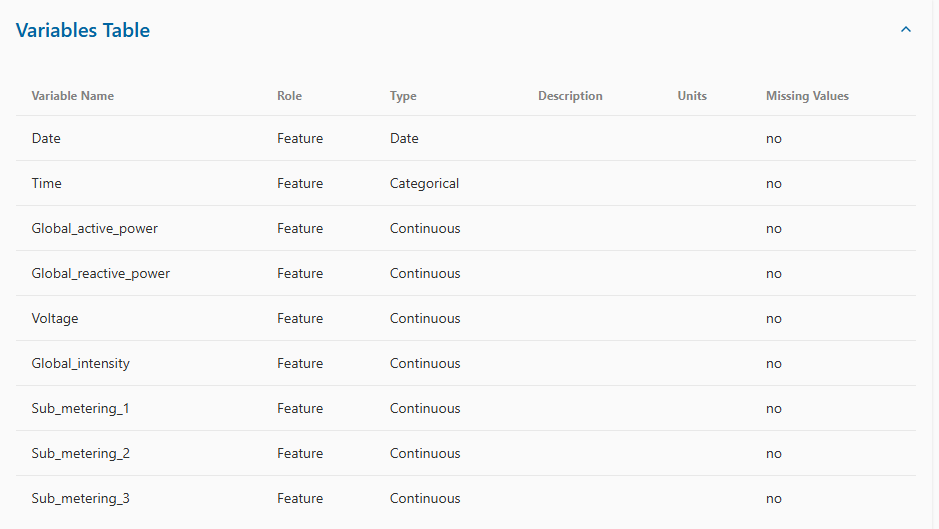

In [3]:
# Importing the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
# Load dataset
file_path = "household_power_consumption/household_power_consumption.txt"  # Update with your actual path
df = pd.read_csv(file_path, sep=';', low_memory=False, na_values=['?'])

In [5]:
#  Convert Date & Time to Datetime Format
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(columns=['Date', 'Time'])  # Drop original columns
df = df.set_index('datetime')  # Set datetime as index
df = df.astype(float)  # Convert all columns to float

In [6]:
print(df[df.isna().any(axis=1)].count)

<bound method DataFrame.count of                      Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-21 11:23:00                  NaN                    NaN      NaN   
2006-12-21 11:24:00                  NaN                    NaN      NaN   
2006-12-30 10:08:00                  NaN                    NaN      NaN   
2006-12-30 10:09:00                  NaN                    NaN      NaN   
2007-01-14 18:36:00                  NaN                    NaN      NaN   
...                                  ...                    ...      ...   
2010-09-28 19:09:00                  NaN                    NaN      NaN   
2010-09-28 19:10:00                  NaN                    NaN      NaN   
2010-09-28 19:11:00                  NaN                    NaN      NaN   
2010-09-28 19:12:00                  NaN                    NaN      NaN   
2010-10-24 15:35:00                  NaN               

In [7]:
# df = df.interpolate()  # Linear interpolation to fill missing values
# df = df.dropna()  # Drop remaining NaN values
# df.reset_index()

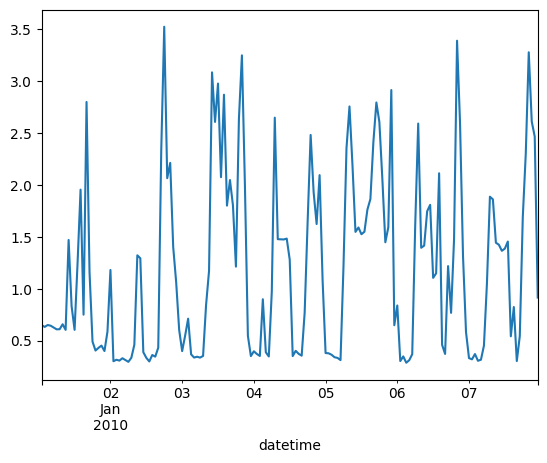

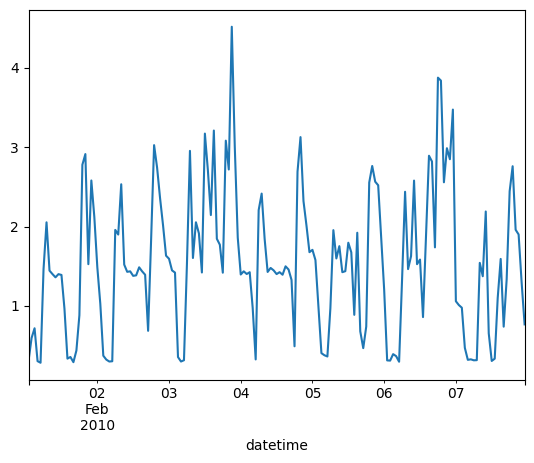

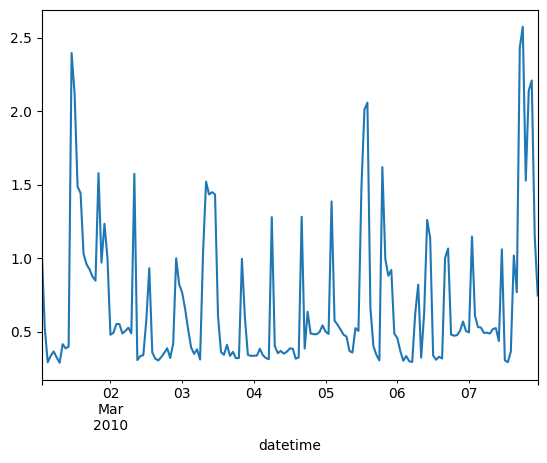

<Axes: xlabel='datetime'>

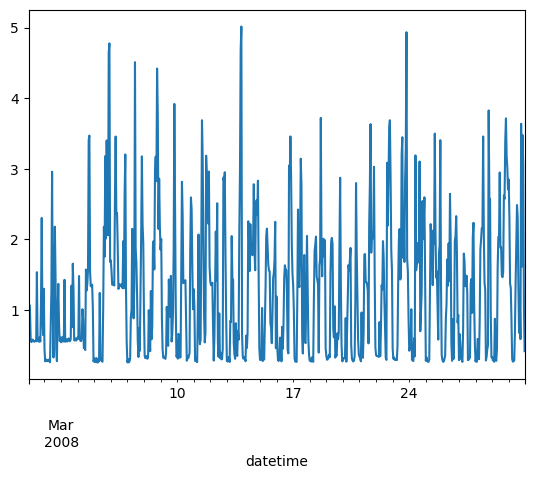

In [8]:
df_h = df.resample('h').mean() 
# date == 'month-day-year'
df_h.loc[(df_h.index > '01-01-2010') & (df_h.index < '01-08-2010'), 'Global_active_power'].plot() # What a week of data looks like (in an hourly resampling)
plt.show()
df_h.loc[(df_h.index > '02-01-2010') & (df_h.index < '02-08-2010'), 'Global_active_power'].plot() 
plt.show()
df_h.loc[(df_h.index > '03-01-2010') & (df_h.index < '03-08-2010'), 'Global_active_power'].plot() 

plt.show()
df_h.loc[(df_h.index > '03-01-2008') & (df_h.index < '03-31-2008'), 'Global_active_power'].plot() 

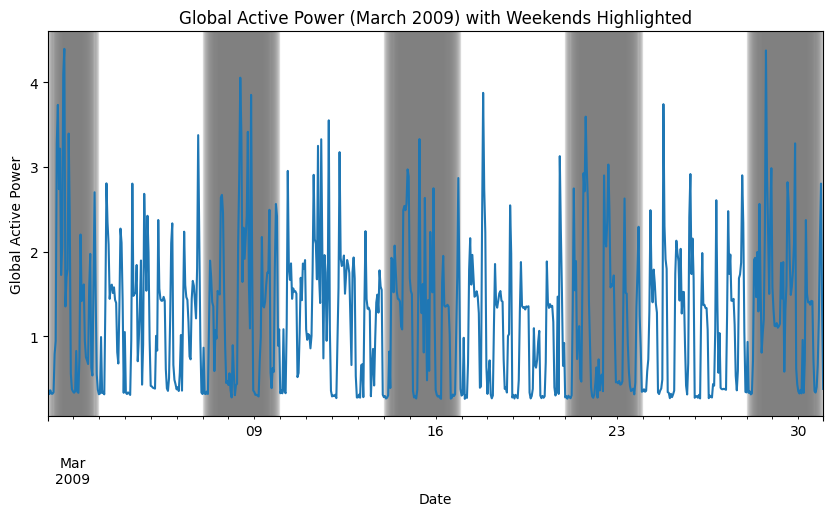

In [9]:
# Assuming df_h.index is a DateTimeIndex
df_filtered = df_h.loc[(df_h.index > '03-01-2009') & (df_h.index < '03-31-2009')]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
df_filtered['Global_active_power'].plot(ax=ax)

# Highlight weekends
for date in df_filtered.index:
    if date.weekday() >= 5:  # Saturday (5) or Sunday (6)
        ax.axvspan(date, date + pd.Timedelta(days=1), color='gray', alpha=0.2)

plt.title('Global Active Power (March 2009) with Weekends Highlighted')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()

In [10]:
# df_resampled = df.resample('h').mean()  # Aggregates to hourly average
# df_resampled = df.resample('W').mean()  # Aggregates to monthly average
df_resampled = df.resample('w').mean()  # Aggregates to weekly average

C:\Users\ihebe\AppData\Local\Temp\ipykernel_15712\3660163422.py:3: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_resampled = df.resample('w').mean()  # Aggregates to weekly average


In [11]:
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
df_resampled['month'] = df_resampled.index.month
df_resampled['weekend'] = (df_resampled.index.weekday >= 5).astype(int)

# df_resampled.dropna(inplace=True)
# df_resampled.reset_index()
df_resampled = df_resampled.interpolate()

In [12]:
import matplotlib.pyplot as plt

def plot_aggregated_time_series(df, freq, value_column='Global_active_power'):
    """
    Aggregates time series data and plots it based on the given frequency.

    Parameters:
    - df: Pandas DataFrame with a DateTime index.
    - freq: Resampling frequency ('H', 'D', 'W', 'M', 'Y' for hourly, daily, weekly, monthly, yearly).
    - value_column: The column to aggregate and plot.

    Returns:
    - A time series plot of the aggregated data.
    """
    # Define frequency labels for the title
    freq_labels = {
        'h': 'Hourly',
        'd': 'Daily',
        'W': 'Weekly',
        'ME': 'Monthly',
        'YE': 'Yearly'
    }

    # if freq not in freq_labels:
    #     raise ValueError("Invalid frequency. Use 'h' (hourly), 'D' (daily), 'W' (weekly), 'ME' (monthly), or 'YE' (yearly).")

    # Resample (aggregate) data
    df_temp = df.resample(freq)[value_column].mean()

    # Plot the resampled time series
    plt.figure(figsize=(12, 5))
    plt.plot(df_temp, label=f'{freq_labels[freq]} Aggregation')
    # plt.plot(df_resampled.index, df_resampled['Global_active_power'], label=f'{freq_labels[freq]} Aggregation')
    plt.xlabel('Time')
    plt.ylabel(value_column)
    plt.title(f'{freq_labels[freq]} Aggregated Time Series')
    plt.legend()
    plt.grid(True)
    plt.show()


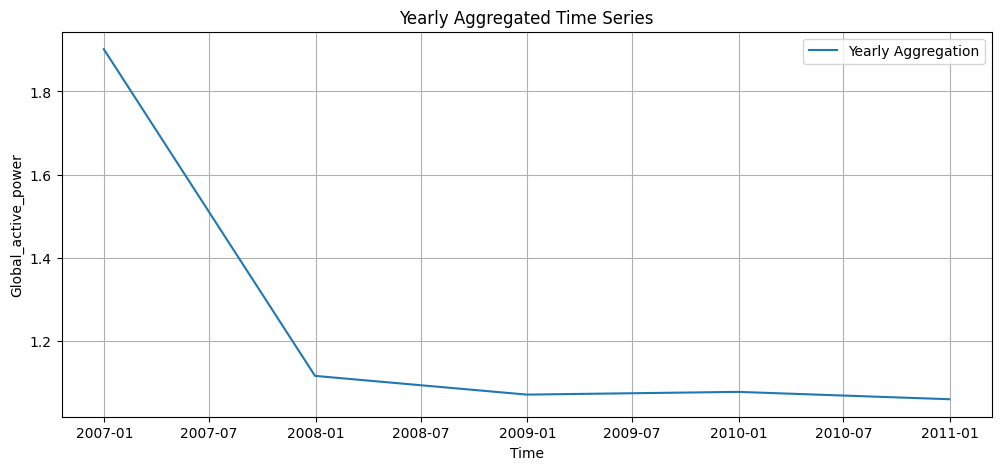

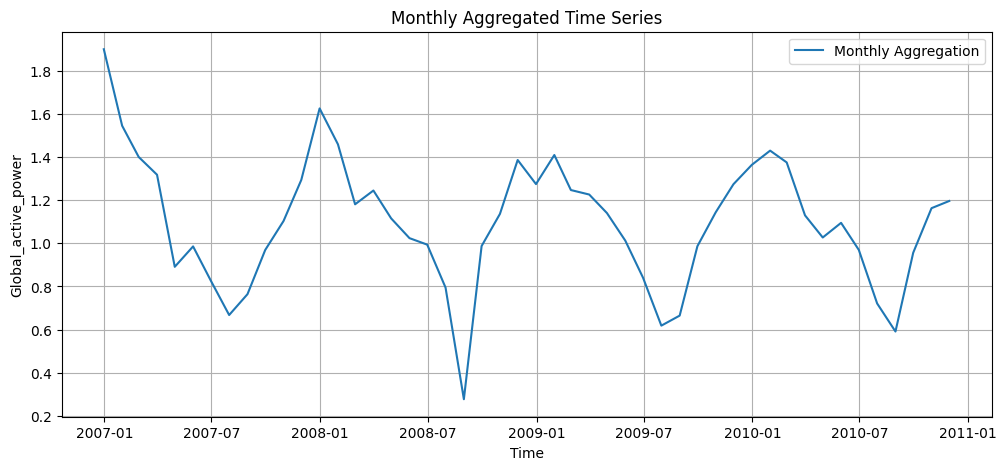

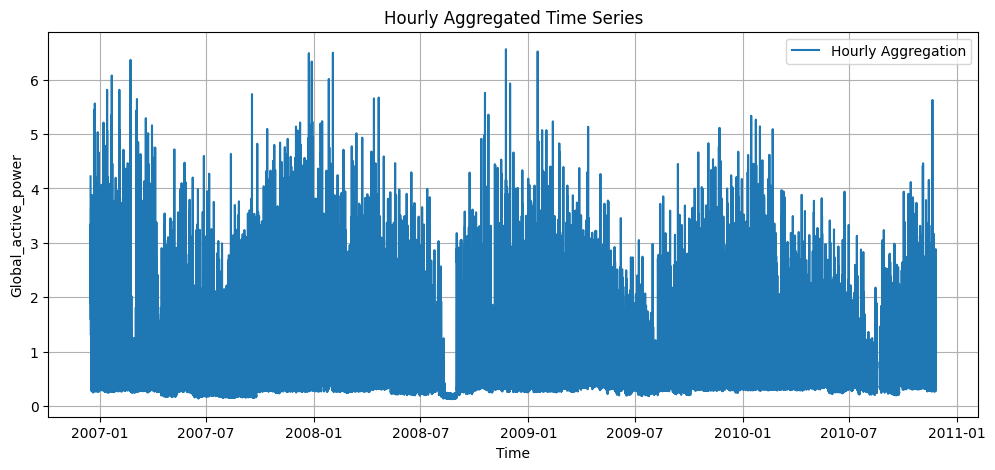

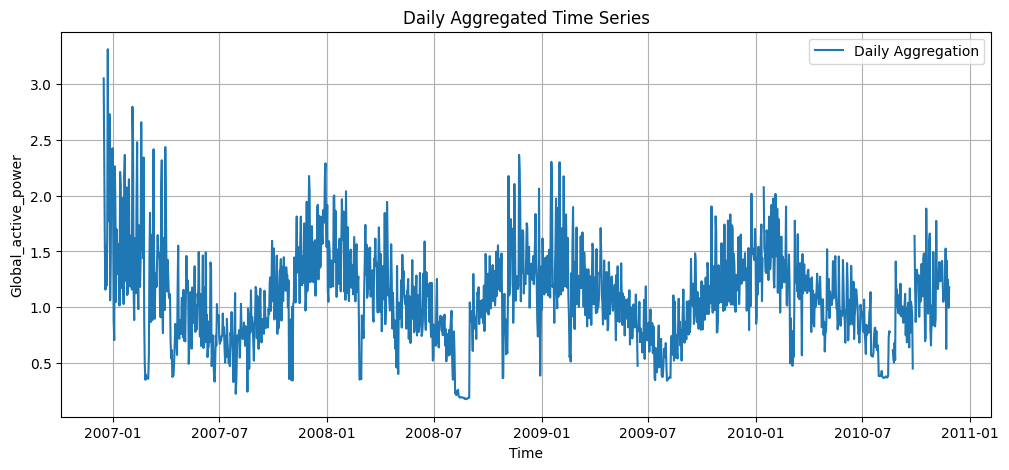

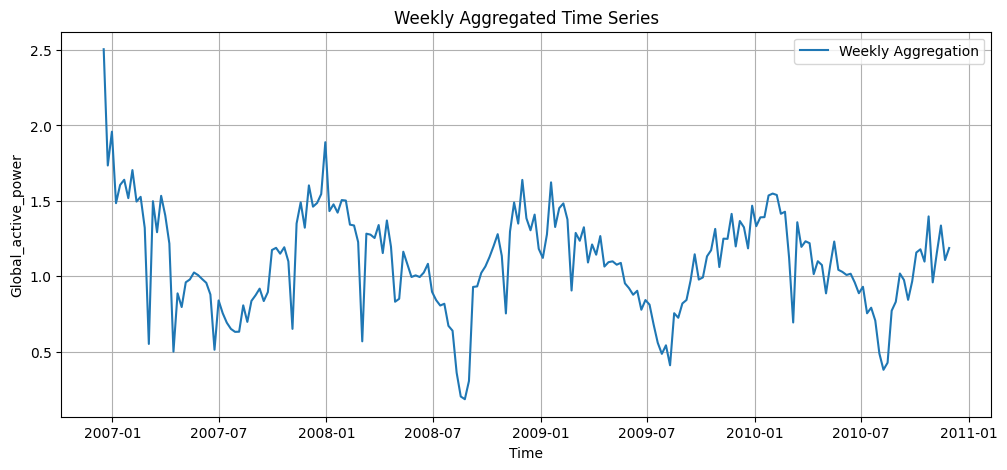

In [13]:
plot_aggregated_time_series(df, 'YE')  # Yearly
plot_aggregated_time_series(df, 'ME')  # Monthly
plot_aggregated_time_series(df, 'h')  # Hourly
plot_aggregated_time_series(df, 'd')  # Daily
plot_aggregated_time_series(df, 'W')  # Weekly


In [14]:
df_resampled[df_resampled.isna().any(axis=1)]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,weekend
datetime,,,,,,,,,,,


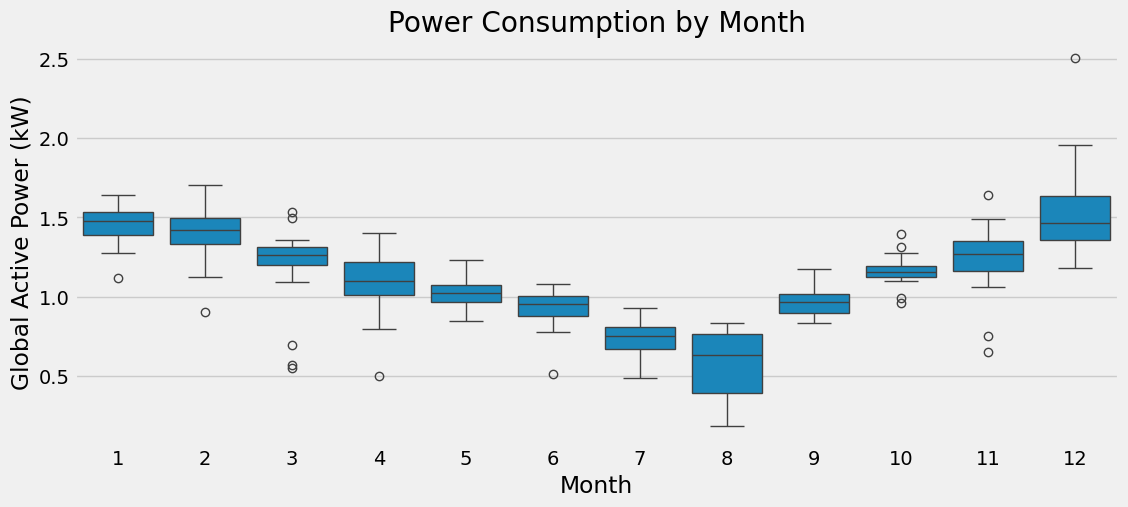

In [15]:
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Ensure datetime index
df_viz = df_resampled.reset_index()
df_viz['Year'] = df_viz['datetime'].dt.year
df_viz['Month'] = df_viz['datetime'].dt.month
df_viz['Day'] = df_viz['datetime'].dt.day
df_viz['Hour'] = df_viz['datetime'].dt.hour

plt.figure(figsize=(12, 5))
sns.boxplot(x='Month', y='Global_active_power', data=df_viz)
plt.xlabel('Month')
plt.ylabel('Global Active Power (kW)')
plt.title('Power Consumption by Month')
plt.show()


The boxplot shows that the power consumption is highest during winter (months 01-02 and 12), and lowest during summer (august). This makes sense due to the high usage of heating devices during winter and perhaps because the users go on vacation in july-august (which is typical in Paris).  


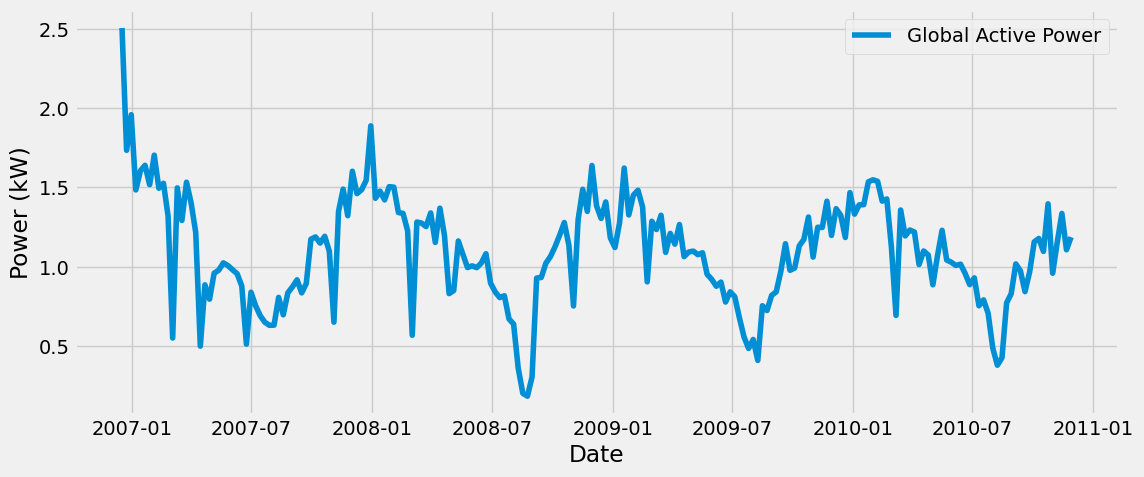

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(df_resampled.index, df_resampled['Global_active_power'], label='Global Active Power')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

In [17]:
# target = 'Global_active_power'  # This is what we want to predict
# X = df_resampled[[target]]  # Univariate time series
# train_size = int(len(X) * 0.8)  # Use 80% for training
# train, test = X.iloc[:train_size], X.iloc[train_size:]

In [18]:
has_na = df_resampled.isna().any().any()  # Checks for NaN
has_inf = np.isinf(df_resampled).any().any()  # Checks for Inf

print(f"Contains NaN: {has_na}")  # Output: True
print(f"Contains Inf: {has_inf}")  # Output: True
df_filtered = df_resampled[(df_resampled.isna()).any(axis=1)]
print(df_filtered)

Contains NaN: False
Contains Inf: False
Empty DataFrame
Columns: [Global_active_power, Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3, hour, day_of_week, month, weekend]
Index: []


In [19]:
# Test stationarity on Global_active_power
result = adfuller(df_resampled['Global_active_power'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:', result[4])

if result[1] < 0.05:
    print("✅ Data is stationary (p < 0.05)")
else:
    print("❌ Data is NOT stationary (p >= 0.05)")


ADF Statistic: -4.289294873351963
p-value: 0.00046356056515100766
Critical Values: {'1%': -3.4626576734812318, '5%': -2.8757444215841326, '10%': -2.5743412314098753}
✅ Data is stationary (p < 0.05)


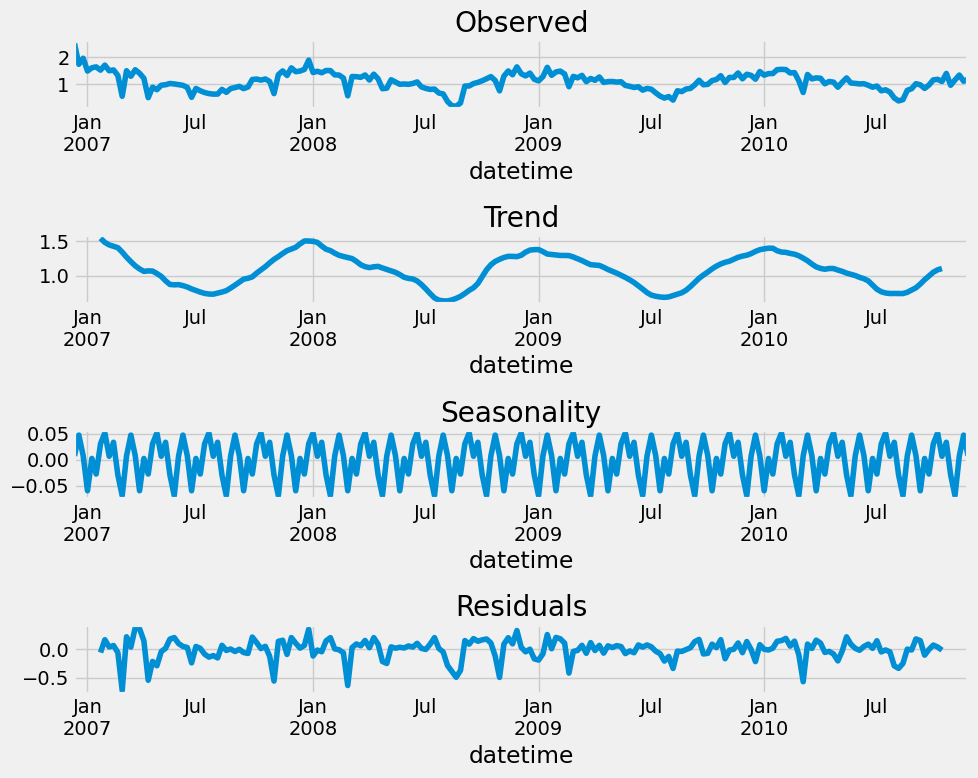

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
decomposition = seasonal_decompose(df_resampled['Global_active_power'], model='additive', period=12)

# Plot components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

decomposition.observed.plot(ax=ax1, legend=False, title='Observed')
decomposition.trend.plot(ax=ax2, legend=False, title='Trend')
decomposition.seasonal.plot(ax=ax3, legend=False, title='Seasonality')
decomposition.resid.plot(ax=ax4, legend=False, title='Residuals')

plt.tight_layout()
plt.show()


## Arima Model

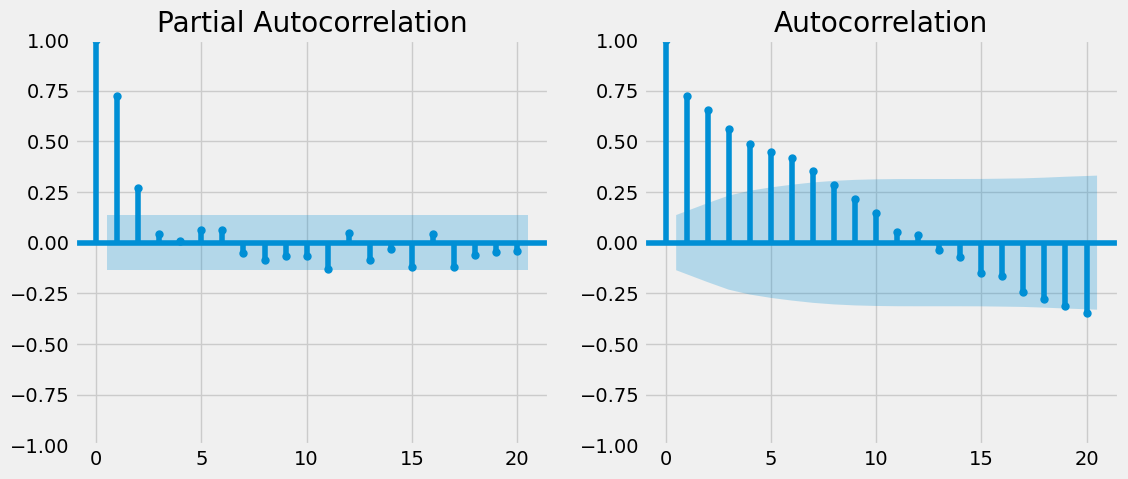

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_pacf(df_resampled['Global_active_power'].dropna(), lags=20, ax=plt.gca())  # PACF plot
plt.subplot(122)
plot_acf(df_resampled['Global_active_power'].dropna(), lags=20, ax=plt.gca())  # ACF plot
plt.show()

In [22]:
train_size = int(len(df_resampled) * 0.7)  # 80% for training
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]

# train_size = int(len(df_resampled) * 0.10)  # 80% for training
# ignore_size = int(len(df_resampled) * 0.9)
# test_size = int(len(df_resampled) * 0.1*0.2)
# train, test = df_resampled.iloc[ignore_size:len(df_resampled)-test_size], df_resampled.iloc[len(df_resampled)-test_size:]
print(len(train), len(test))

144 63


In [23]:
from pmdarima import auto_arima

# Find the best (p, d, q) values automatically
auto_arima_model = auto_arima(
    train['Global_active_power'], 
    seasonal=True,  # Set to True for SARIMA (seasonal data)
    trace=True,  # Shows output for different (p, d, q) values
    # suppress_warnings=True,
    # start_p=0,
    # max_p=4,

    start_p=1,  
    max_p=6,  
    start_q=0,  
    max_q=4,  
    start_P=0,  
    max_P=4,  
    start_Q=0,  
    max_Q=4,  

    stepwise=True  # Efficient parameter search
)

# Get the best order
best_order = auto_arima_model.order
print(f"Best ARIMA order: {best_order}")

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-0.255, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=122.358, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=62.044, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=451.540, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-9.410, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-7.705, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7.750, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-9.549, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7.678, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=34.628, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-8.343, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5.850, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.871 seconds
Best ARIMA order: (1, 0, 1)


In [24]:
from statsmodels.tsa.arima.model import ARIMA

# order = best_order
order = (2, 0, 1) # d=0 because data is stationary 
# Train ARIMA model
model = ARIMA(train['Global_active_power'], order=best_order)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                  144
Model:                  ARIMA(1, 0, 1)   Log Likelihood                   8.774
Date:                 Sun, 23 Mar 2025   AIC                             -9.549
Time:                         16:02:55   BIC                              2.331
Sample:                     12-17-2006   HQIC                            -4.721
                          - 09-13-2009                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1653      0.162      7.201      0.000       0.848       1.482
ar.L1          0.9292      0.032     28.955      0.000       0.866       0.992
ma.L1         -0.3561      0.079     -4.485 

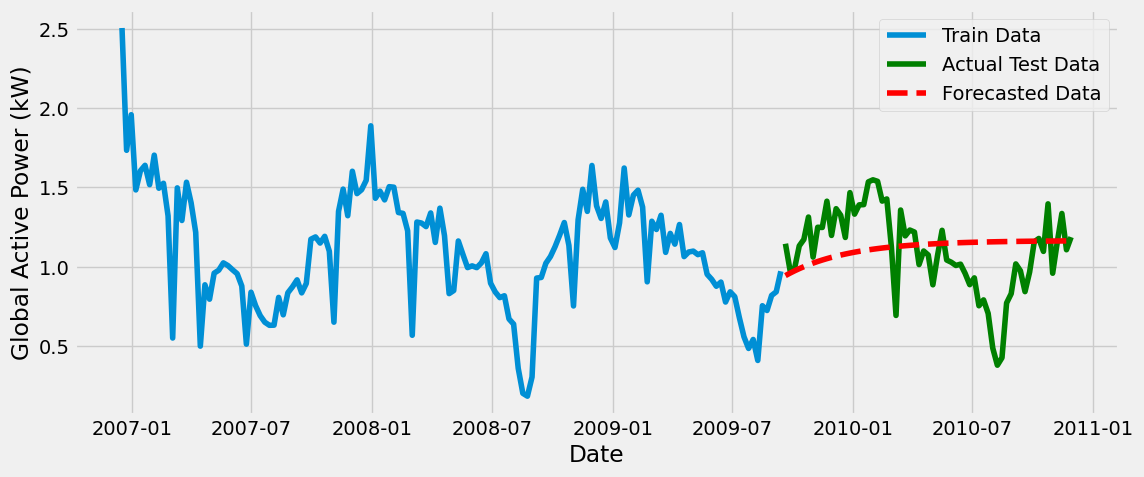

In [25]:
forecast_steps = len(test)  # Predict same length as test set
forecast = model_fit.forecast(steps=forecast_steps)

# Create forecast date range
forecast_index = test.index  # Use test set's timestamps

# Convert to DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)

# Plot actual vs. forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train.index, train['Global_active_power'], label='Train Data')
plt.plot(test.index, test['Global_active_power'], label='Actual Test Data', color='green')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Data', linestyle='dashed', color='red')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

In [26]:
forecast_df

,Forecast
datetime,
2009-09-20,0.944188
2009-09-27,0.959847
2009-10-04,0.974397
2009-10-11,0.987917
2009-10-18,1.000478
...,...
2010-10-31,1.162166
2010-11-07,1.162387
2010-11-14,1.162593


## SARIMA

In [28]:
from pmdarima import auto_arima

# Auto-select best SARIMA (p, d, q) (P, D, Q, s)
# auto_sarima_model = auto_arima(
#     df_resampled['Global_active_power'],
#     seasonal=True,
#     m=49,  # RECHECK - Seasonality period (daily pattern, 24 hours) RECHECK
#     trace=True,
#     suppress_warnings=True,
#     stepwise=True
# )

auto_sarima_model = auto_arima(
    df_resampled['Global_active_power'],
    seasonal=True,
    m=50,   # Adjust seasonality period if necessary
    start_p=0, max_p=4,  # Expanding AR range
    start_q=0, max_q=10,  # Expanding MA range
    # start_P=0, max_P=4,  # Expanding Seasonal AR range
    # start_Q=0, max_Q=10,  # Expanding Seasonal MA range
    d=1, D=1,  # Allowing differencing
    trace=True,
    suppress_warnings=True,
    stepwise=False
)

# Get the best (p, d, q) and (P, D, Q, s)
best_order = auto_sarima_model.order
best_seasonal_order = auto_sarima_model.seasonal_order
print(f"Best SARIMA order: {best_order}, Seasonal order: {best_seasonal_order}")


 ARIMA(0,1,0)(0,1,0)[50]             : AIC=84.173, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[50]             : AIC=62.208, Time=5.90 sec
 ARIMA(0,1,0)(0,1,2)[50]             : AIC=63.996, Time=11.49 sec
 ARIMA(0,1,0)(1,1,0)[50]             : AIC=65.718, Time=3.77 sec
 ARIMA(0,1,0)(1,1,1)[50]             : AIC=64.073, Time=10.80 sec
 ARIMA(0,1,0)(1,1,2)[50]             : AIC=inf, Time=62.56 sec
 ARIMA(0,1,0)(2,1,0)[50]             : AIC=62.491, Time=12.73 sec
 ARIMA(0,1,0)(2,1,1)[50]             : AIC=inf, Time=41.60 sec
 ARIMA(0,1,0)(2,1,2)[50]             : AIC=inf, Time=70.78 sec
 ARIMA(0,1,1)(0,1,0)[50]             : AIC=52.500, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[50]             : AIC=inf, Time=14.30 sec
 ARIMA(0,1,1)(0,1,2)[50]             : AIC=inf, Time=19.00 sec
 ARIMA(0,1,1)(1,1,0)[50]             : AIC=37.922, Time=6.87 sec
 ARIMA(0,1,1)(1,1,1)[50]             : AIC=inf, Time=25.78 sec
 ARIMA(0,1,1)(1,1,2)[50]             : AIC=inf, Time=48.84 sec
 ARIMA(0,1,1)(2,1,0)[50]            

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Model training

# Train SARIMA with best orders
model = SARIMAX(df_resampled['Global_active_power'], 
                order=best_order, 
                seasonal_order=best_seasonal_order) # Best SARIMA order: (2, 1, 0), Seasonal order: (1, 1, 0, 50) WEEKLY

model_fit = model.fit()

# Print model summary
print(model_fit.summary())


c:\Users\ihebe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:                  Global_active_power   No. Observations:                  207
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 50)   Log Likelihood                  -9.161
Date:                              Sun, 23 Mar 2025   AIC                             28.323
Time:                                      17:36:19   BIC                             43.572
Sample:                                  12-17-2006   HQIC                            34.516
                                       - 11-28-2010                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5862      0.074     -7.915      0.000      -0.731      -0.441
ma.L2         -0.07

DatetimeIndex(['2010-12-05', '2010-12-12', '2010-12-19', '2010-12-26',
               '2011-01-02', '2011-01-09', '2011-01-16', '2011-01-23',
               '2011-01-30', '2011-02-06', '2011-02-13', '2011-02-20',
               '2011-02-27', '2011-03-06', '2011-03-13', '2011-03-20',
               '2011-03-27', '2011-04-03', '2011-04-10', '2011-04-17',
               '2011-04-24', '2011-05-01', '2011-05-08', '2011-05-15',
               '2011-05-22', '2011-05-29', '2011-06-05', '2011-06-12',
               '2011-06-19', '2011-06-26', '2011-07-03', '2011-07-10',
               '2011-07-17', '2011-07-24', '2011-07-31', '2011-08-07',
               '2011-08-14', '2011-08-21', '2011-08-28', '2011-09-04',
               '2011-09-11', '2011-09-18', '2011-09-25', '2011-10-02',
               '2011-10-09', '2011-10-16', '2011-10-23', '2011-10-30',
               '2011-11-06', '2011-11-13'],
              dtype='datetime64[ns]', freq='W-SUN')


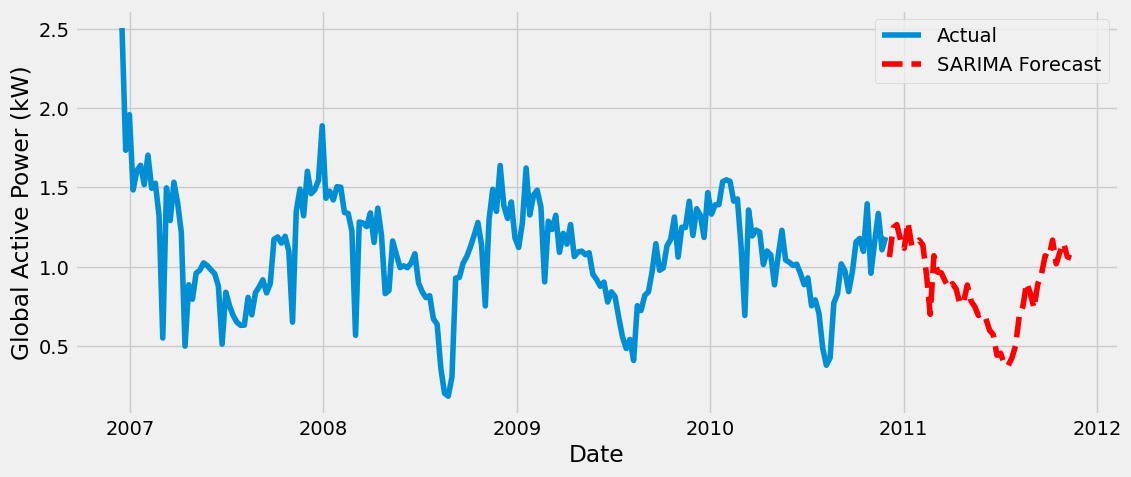

In [30]:
forecast_steps = 50  # Predict next 24 units
forecast = model_fit.forecast(steps=forecast_steps)

# print(forecast)
# Create forecast date range
forecast_index = pd.date_range(start=df_resampled.index[-1], periods=forecast_steps + 1, freq='W')[1:]

print(forecast_index)
# Convert to DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df_resampled.index, df_resampled['Global_active_power'], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='SARIMA Forecast', linestyle='dashed', color='red')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()


In [31]:
lowest_20 = df_resampled['Global_active_power'].nsmallest(20)
print(lowest_20)

#          2008-08-24 == 0.183998     49 values      2009-08-09 == 0.409178     51 values      2010-08-08 == 0.379187    lowest pred = 2011-07-24  
count = df_resampled.loc[(df_resampled.index > '2008-08-24') & (df_resampled.index < '2009-08-09')].shape[0]

# Alternatively
count = len(df_resampled.loc[(df_resampled.index > '2009-08-09') & (df_resampled.index < '2010-08-08')])

print(count)


datetime
2008-08-24    0.183998
2008-08-17    0.202084
2008-08-31    0.304876
2008-08-10    0.359876
2010-08-08    0.379187
2009-08-09    0.409178
2010-08-15    0.426198
2009-07-26    0.484843
2010-08-01    0.487084
2007-04-15    0.499497
2007-06-24    0.512064
2009-08-02    0.541494
2007-03-04    0.550639
2009-07-19    0.558300
2008-03-02    0.567953
2007-07-29    0.630839
2007-08-05    0.631708
2008-08-03    0.638397
2007-07-22    0.650334
2007-11-04    0.650565
Name: Global_active_power, dtype: float64
51


In [32]:
# Step 1: Split Data
train_size = int(len(df_resampled) * 0.8)  # 80% train, 20% test
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]

# Step 2: AutoSARIMA to Find Best Parameters
auto_sarima_model = auto_arima(
    train['Global_active_power'],
    seasonal=True,  
    m=50,  # Adjust seasonality period if needed
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    start_P=0, max_P=5,
    start_Q=0, max_Q=5,
    d=1, D=1,  
    trace=True,
    # suppress_warnings=True,
    stepwise=False,
    n_jobs=-1
)

# Extract Best Parameters
best_order = auto_sarima_model.order
best_seasonal_order = auto_sarima_model.seasonal_order
print(f"Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}")


OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

In [ ]:
# best_order, best_seasonal_order = (1, 0, 0), (1, 1, 0, 50)   #MAE: 0.1913    RMSE: 0.2266
# best_order, best_seasonal_order = (0, 1, 3), (1, 1, 0, 50) #MAE: 0.2043   RMSE: 0.2568
# best_order, best_seasonal_order = (2, 1, 0), (1, 1, 0, 50)  # MAE: 0.4629  RMSE: 0.5190


print(best_order, best_seasonal_order)
# Step 3: Train SARIMA Model
sarima_model = SARIMAX(
    train['Global_active_power'],
    order=best_order,
    seasonal_order=best_seasonal_order
)

model_fit = sarima_model.fit()

# Step 4: Forecast on Test Set
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

(0, 1, 3) (1, 1, 0, 50)


datetime
2010-02-14    1.413845
2010-02-21    1.427403
2010-02-28    1.123678
2010-03-07    0.692982
2010-03-14    1.357746
Freq: W-SUN, Name: Global_active_power, dtype: float64


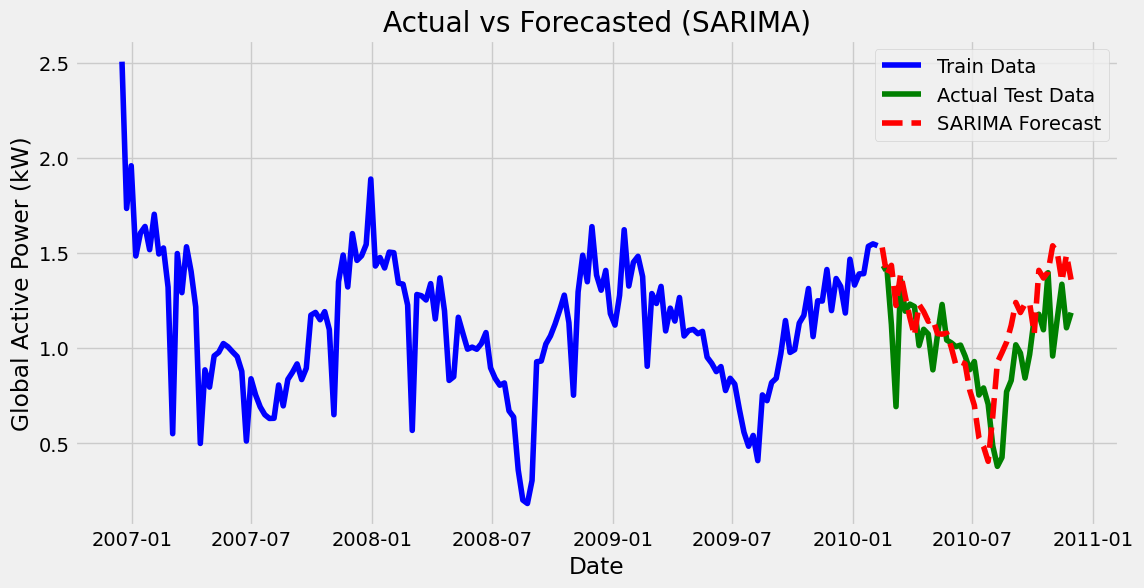

In [ ]:
# Step 5: Plot Actual vs Forecasted Values
print(test['Global_active_power'].head())
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Global_active_power'], label='Train Data', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Actual Test Data', color='green')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.title('Actual vs Forecasted (SARIMA)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 6: Evaluate Performance
mae = mean_absolute_error(test['Global_active_power'], forecast)
rmse = np.sqrt(mean_squared_error(test['Global_active_power'], forecast))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.2043
RMSE: 0.2568
